In [1]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

In [2]:
base_path = '../../datasets/'

dataset_path = os.path.join(base_path, '4-dataset')
train_path = os.path.join(base_path, 'training')
valid_path = os.path.join(base_path, 'validation')

In [3]:
class_names = []
split_ratio = 0.6

# Loop melalui setiap folder (menggunakan NPM sebagai nama folder)
for npm_folder in os.listdir(dataset_path):
  folder_path = os.path.join(dataset_path, npm_folder)

  # Cek apakah folder tersebut adalah direktori
  if os.path.isdir(folder_path):
    # List semua file dalam folder tersebut
    files = os.listdir(folder_path)

    # Jika ada lebih dari 2 file, kita akan melakukan split
    if len(files) >= 2:
      class_names.append(npm_folder)
      # Buat folder training dan validation jika belum ada
      os.makedirs(os.path.join(train_path, npm_folder), exist_ok=True)
      os.makedirs(os.path.join(valid_path, npm_folder), exist_ok=True)

      # Hitung jumlah file yang akan dipindahkan ke training
      num_files_to_move = int(len(files) * split_ratio)

      # Acak urutan file
      random.shuffle(files)

      # Pindahkan file ke folder training dan validation
      for i, file in enumerate(files):
        if i < num_files_to_move:
          # Pindahkan ke folder training
          shutil.copy(os.path.join(folder_path, file), os.path.join(train_path, npm_folder, file))
        else:
          # Pindahkan ke folder validation
          shutil.copy(os.path.join(folder_path, file), os.path.join(valid_path, npm_folder, file))
    else:
        print(f"Folder {npm_folder} kurang dari 2 file. Skipping...")

print("Data splitting completed.")

Data splitting completed.


In [4]:
num_classes = len(class_names)

In [5]:
model = ResNet101(input_shape=(128,128,3), include_top=False, weights="imagenet")
model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [6]:
for layers in model.layers:
    layers.trainable=False

In [7]:
arc = Model(inputs=model.input, outputs=Dense(num_classes, activation="softmax")(Flatten()(model.output)))
arc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

 rmalization)                                                                                     
                                                                                                  
 conv2_block1_3_bn (BatchNo  (None, 32, 32, 256)          1024      ['conv2_block1_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block1_add (Add)      (None, 32, 32, 256)          0         ['conv2_block1_0_bn[0][0]',   
                                                                     'conv2_block1_3_bn[0][0]']   
                                                                                                  
 conv2_block1_out (Activati  (None, 32, 32, 256)          0         ['conv2_block1_add[0][0]']    
 on)                                                                                              
          

In [8]:
train_data_gen = ImageDataGenerator(
    featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
    samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, 
    width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.3,
    zoom_range=0.2, channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=True, vertical_flip=False, rescale=1/255, preprocessing_function=preprocess_input,
    data_format=None, validation_split=0.0, interpolation_order=1, dtype=None
)
validate_data_gen = ImageDataGenerator(
    featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
    samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, 
    width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0,
    zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=preprocess_input,
    data_format=None, validation_split=0.0, interpolation_order=1, dtype=None
)

In [9]:
train_gen = train_data_gen.flow_from_directory(train_path, (128,128), batch_size=32, class_mode='categorical')
validate_gen = validate_data_gen.flow_from_directory(valid_path, (128,128), batch_size=32, class_mode='categorical')

Found 436 images belonging to 4 classes.


Found 293 images belonging to 4 classes.


In [10]:
arc.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
saveBestModel = tf.keras.callbacks.ModelCheckpoint('../../datasets/resnet101_tf-import.h5',
                                                   monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [12]:
history = arc.fit(train_gen, steps_per_epoch=5,
          epochs=100,
          validation_data=validate_gen,
          callbacks=[saveBestModel]
          )

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.4363 - accuracy: 0.3250
Epoch 1: val_accuracy improved from -inf to 0.30717, saving model to ../../datasets\resnet101_tf-import.h5


c:\Users\ramad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 12s 2s/step - loss: 1.4363 - accuracy: 0.3250 - val_loss: 1.4045 - val_accuracy: 0.3072
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.3913 - accuracy: 0.3313
Epoch 2: val_accuracy did not improve from 0.30717
5/5 [==============================] - 13s 3s/step - loss: 1.3913 - accuracy: 0.3313 - val_loss: 1.3649 - val_accuracy: 0.2150
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.3436 - accuracy: 0.3649
Epoch 3: val_accuracy improved from 0.30717 to 0.39932, saving model to ../../datasets\resnet101_tf-import.h5
5/5 [==============================] - 22s 5s/step - loss: 1.3436 - accuracy: 0.3649 - val_loss: 1.2872 - val_accuracy: 0.3993
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 1.2793 - accuracy: 0.4750
Epoch 4: val_accuracy improved from 0.39932 to 0.41980, saving model to ../../datasets\resnet101_tf-import.h5
5/5 [==============================] - 22s 5s/step - loss: 1.2793 - a

In [13]:
best_model = keras.models.load_model('../../datasets/resnet101_tf-import.h5')

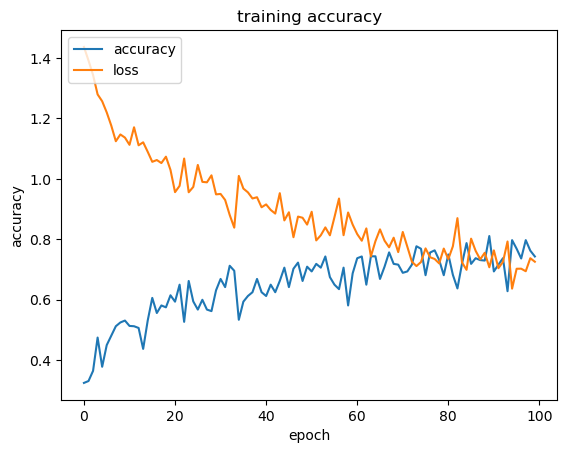

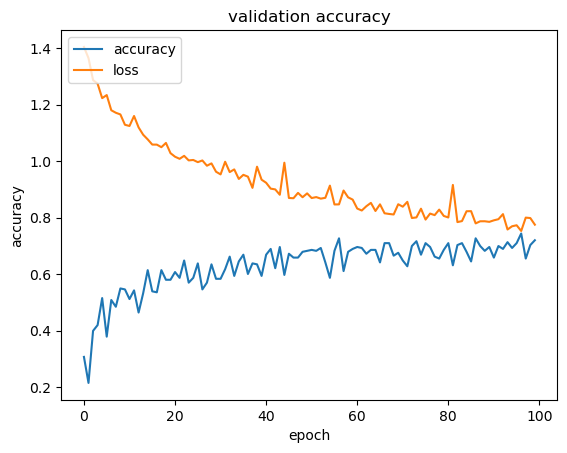

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [15]:
train_gen.class_indices

{'Adriana Lima': 0,
 'Alex Lawther': 1,
 'Alexandra Daddario': 2,
 'Alvaro Morte': 3}

In [16]:
labels = train_gen.class_indices
labels = dict((v,k) for k, v in labels.items())
labels

{0: 'Adriana Lima',
 1: 'Alex Lawther',
 2: 'Alexandra Daddario',
 3: 'Alvaro Morte'}

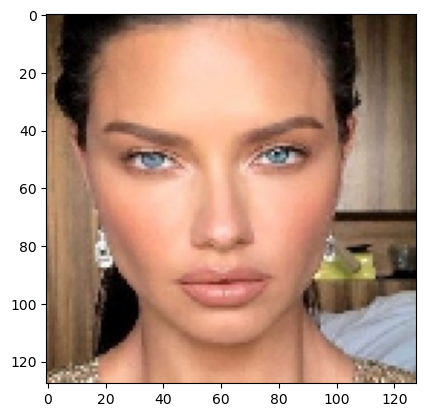

1/1 [==============================] - 0s 71ms/step
Prediksi :  ['Alexandra Daddario']
[0.01787090115249157, 0.11007051169872284, 0.8720578551292419, 7.581851946270035e-07]


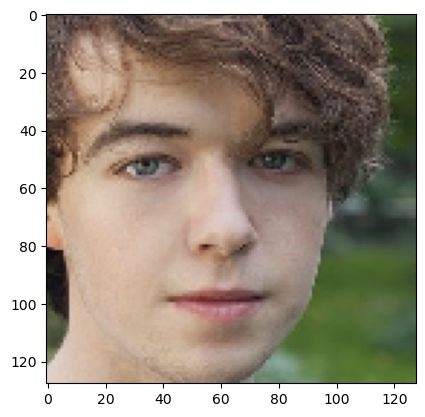

1/1 [==============================] - 0s 67ms/step
Prediksi :  ['Alex Lawther']
[6.638992999796756e-08, 0.9999895095825195, 1.0381800166214816e-05, 4.24680984822956e-11]


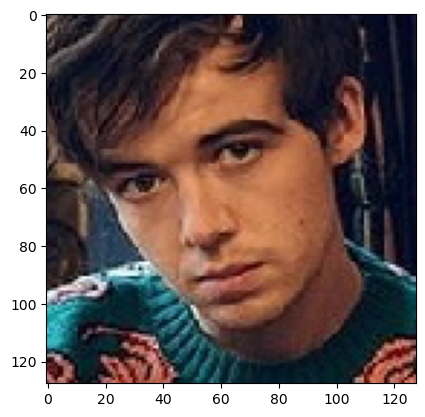

1/1 [==============================] - 0s 72ms/step
Prediksi :  ['Alvaro Morte']
[0.26637130975723267, 0.05538077652454376, 0.0010339881991967559, 0.6772139072418213]


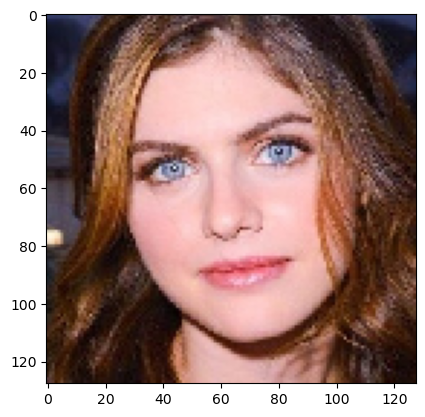

1/1 [==============================] - 0s 63ms/step
Prediksi :  ['Alexandra Daddario']
[0.008152063935995102, 6.929204232619668e-07, 0.99184650182724, 6.985295613048947e-07]


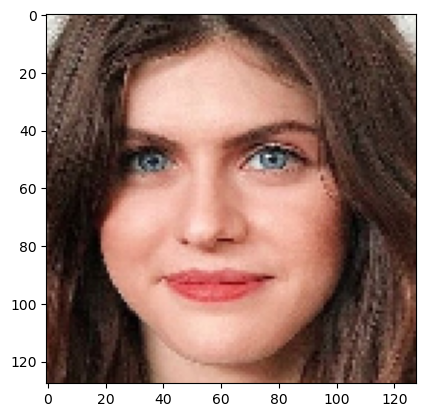

1/1 [==============================] - 0s 72ms/step
Prediksi :  ['Alexandra Daddario']
[1.5335156149376417e-06, 2.216892447393093e-08, 0.9999984502792358, 5.239805117573937e-12]


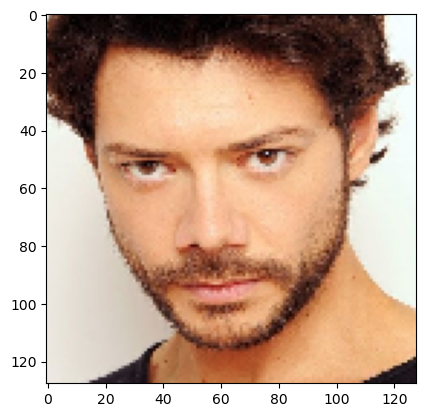

1/1 [==============================] - 0s 67ms/step
Prediksi :  ['Alex Lawther']
[0.1805112361907959, 0.8046002984046936, 0.014740422368049622, 0.0001481231884099543]


In [22]:
test_path = os.path.join(base_path, 'testing')

for image in os.listdir(test_path):
  
  image_path = os.path.join(test_path, image)
  img = load_img(image_path, target_size=(128,128))
  
  plt.imshow(img)
  plt.show()

  X = img_to_array(img)
  X = tf.keras.applications.resnet.preprocess_input(X)

  X = np.expand_dims(X, axis=0)
  images = np.vstack([X])
  val = arc.predict(images)

  predicted_class_index = np.argmax(val, axis=1)
  
  predictions = [labels[k] for k in predicted_class_index]
  print('Prediksi : ', predictions)
  print(val.tolist()[0])